<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import dates
from netCDF4 import num2date,date2num,Dataset
import matplotlib._pylab_helpers
#from joblib import Parallel, delayed
import scipy.interpolate as interpolate
from scipy.stats.mstats import scoreatpercentile
import scipy.stats as stats
from scipy.stats import pearsonr
import pandas as pd
import os,subprocess,time,copy
import scipy
import datetime
import matplotlib.gridspec as gridspec
#import pyart.graph.cm as pcm
#import cPickle as pickle
#import pickle
#import pprint
#import triangle
import corner
import f90nml
%matplotlib inline

In [2]:
from marcus_py_tools import make_edge_vec, xy_from_latlon, latlon_from_xy, walklevel, find_stuff_at_level,haversine

ModuleNotFoundError: No module named 'pyproj'

In [3]:
import re

In [4]:
def walklevel(some_dir, level=1):
    some_dir = some_dir.rstrip(os.path.sep)
    assert os.path.isdir(some_dir)
    num_sep = some_dir.count(os.path.sep)
    for root, dirs, files in os.walk(some_dir):
      yield root, dirs, files
      num_sep_this = root.count(os.path.sep)
      if num_sep + level <= num_sep_this:
        del dirs[:]

In [185]:
matplotlib.rcParams.update({'font.size': 14})

In [61]:
case = 'dycoms'
case_upper = case.upper()

#main_dir = '/home/marcus/marcus_data/E3SM_BOSS_PPE_data/GISS_SCM_PPE/dycoms/'
main_dir = '/data/gelsaess/giss-e3scm-ppe-elsaesser/'+case+'/'
subdir_list = []
num_subdir  = 0
for root,dirs,files in walklevel(main_dir,level=0):
    for dirr in dirs:
        #if dirr.startswith('SCM_'+case_upper+'_jingbo'):
        if dirr.startswith('SCM_'+case_upper+'_gse'):
            subdir_list.append(dirr)
            num_subdir += 1
subdir_list = sorted(subdir_list)
subdir_list = subdir_list[1:]
num_subdir -= 1
print(num_subdir,subdir_list[-1])

850 SCM_DYCOMS_gse850F110


In [62]:
#..Pick one. First see if we can read parameters
par_dict = {}
pars = []
parnames = list()
with open(main_dir+subdir_list[420]+'/I') as myfile:
    for myline in myfile:
        if (myline[0]==' '):
            pass
        else:
            r = re.findall(r'([a-zA-Z]*)=(\S+)',myline)
            for name,val in r:
                if val:
                    pars = np.r_[pars,float(val)]
                parnames = parnames + [name]
            idict={name:float(val) for name,val in r}
            par_dict.update(idict)

In [63]:
print(par_dict)
print(pars.shape)
print(len(parnames))

{'debdecaytime': 2150.66, 'mc': 42.159, 'xs': 110.259, 'qc': 0.000122477, 'multiplier': 0.639139, 'mstcnv': 10.6449, '': 3.31033, 'urelscale': 65.1935, 'dpscale': 64.3072, 'scale': 0.000714371, 'fevapfac': 0.0327813, 'fac': 1.00092, 'max': 113.406, 'detbyent': 0.357525, 'dd': 5.68312e-05, 'overshoot': 0.270718, 'aspcp': 0.139813, 'fddrt': 0.60429, 'tfmc': 255.196, 'env': 5.26882, 'homf': 237.609, 'rhcsl': 0.833764, 'rhctl': 0.932526, 'homfree': 239960.0, 'dcs': 0.000351213, 'rh': 0.970603, 'pow': 0.212904, 'time': 3553.15, 'cn': 0.838203, 'iifn': 8.71985, 'difn': 8.76673, 'ifluffy': 0.19737, 'sfluffy': 0.612629, 'multi': 0.854739, 'mults': 1.25661, 'entrain': 15.1426}
(45,)
45


In [64]:
print(parnames)

['debdecaytime', 'mc', 'xs', 'qc', 'multiplier', 'mstcnv', 'mstcnv', '', '', 'urelscale', 'dpscale', '', '', '', '', 'scale', 'fevapfac', 'fac', 'max', 'fac', 'max', 'detbyent', 'dd', 'overshoot', 'aspcp', 'fac', 'fddrt', 'tfmc', 'env', 'homf', 'rhcsl', 'rhctl', 'homfree', 'dcs', 'rh', 'pow', 'time', 'cn', 'iifn', 'difn', 'ifluffy', 'sfluffy', 'multi', 'mults', 'entrain']


In [94]:
#.. Now let's make a plot or two
idx = 500
#nc = Dataset(main_dir+subdir_list[idx]+'/allsteps.cijh1SCM_'+case_upper+'_jingbo'+str(idx+1).zfill(3)+'F110.nc','r')
nc = Dataset(main_dir+subdir_list[idx]+'/allsteps.cijh1SCM_'+case_upper+'_gse'+str(idx+1).zfill(3)+'F110.nc','r')
time = nc.variables['time'][:]
prec = nc.variables['prec'][:,0,0]
lwp  = nc.variables['lwp'][:,0,0]
nc.close()


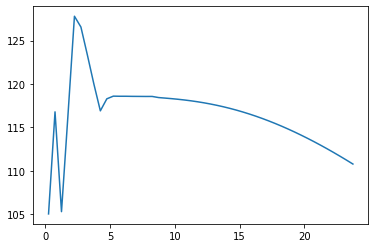

In [95]:
plt.plot(time,lwp)

In [67]:
print(time.shape)

(48,)


In [108]:
numpar = 45
num_main_ppe = 550
nt     = time.shape[0]
allpar = np.zeros((numpar,num_main_ppe))
all_prec = np.zeros((nt,num_main_ppe))
all_lwp  = np.zeros((nt,num_main_ppe))
all_cldtot = np.zeros((nt,num_main_ppe))
all_olr = np.zeros((nt,num_main_ppe))
#..
num_post = 200
allpar_post = np.zeros((numpar,num_post))
all_prec_post = np.zeros((nt,num_post))
all_lwp_post  = np.zeros((nt,num_post))
all_cldtot_post = np.zeros((nt,num_post))
all_olr_post = np.zeros((nt,num_post))

#..Now do this for all ensemble members
for i in range(num_main_ppe):
    #..Pick one. First see if we can read parameters
    par_dict = {}
    pars = []
    parnames = list()
    with open(main_dir+subdir_list[i]+'/I') as myfile:
        for myline in myfile:
            if (myline[0]==' '):
                pass
            else:
                r = re.findall(r'([a-zA-Z]*)=(\S+)',myline)
                for name,val in r:
                    if val:
                        pars = np.r_[pars,float(val)]
                    parnames = parnames + [name]
                idict={name:float(val) for name,val in r}
                par_dict.update(idict)
    #..
    #nc = Dataset(main_dir+subdir_list[i]+'/allsteps.cijh1SCM_'+case_upper+'_jingbo'+str(i+1).zfill(3)+'F110.nc','r')
    nc = Dataset(main_dir+subdir_list[i]+'/allsteps.cijh1SCM_'+case_upper+'_gse'+str(i+1).zfill(3)+'F110.nc','r')
    time = nc.variables['time'][:]
    prec = nc.variables['prec'][:,0,0]
    lwp  = nc.variables['lwp'][:,0,0]
    cldtot = nc.variables['cldtot_2d'][:,0,0]
    nc.close()
    #..
    #nc = Dataset(main_dir+subdir_list[i]+'/allsteps.rijh1SCM_'+case_upper+'_jingbo'+str(i+1).zfill(3)+'F110.nc','r')
    nc = Dataset(main_dir+subdir_list[i]+'/allsteps.rijh1SCM_'+case_upper+'_gse'+str(i+1).zfill(3)+'F110.nc','r')
    olr  = nc.variables['olr'][:,0,0]
    nc.close()
    #
    allpar[:,i]   = pars
    all_prec[:,i] = prec
    all_lwp[:,i]  = lwp
    all_cldtot[:,i] = cldtot
    all_olr[:,i]  = olr
    
#..Now do this for all ensemble members
ii = 0
for i in range(num_main_ppe+100,num_subdir):
    #..Pick one. First see if we can read parameters
    #par_dict = {}
    pars_post = []
    #parnames = list()
    with open(main_dir+subdir_list[i]+'/I') as myfile:
        for myline in myfile:
            if (myline[0]==' '):
                pass
            else:
                r = re.findall(r'([a-zA-Z]*)=(\S+)',myline)
                for name,val in r:
                    if val:
                        pars_post = np.r_[pars_post,float(val)]
                    #parnames = parnames + [name]
                #idict={name:float(val) for name,val in r}
                #par_dict.update(idict)
    #..
    #nc = Dataset(main_dir+subdir_list[i]+'/allsteps.cijh1SCM_'+case_upper+'_jingbo'+str(i+1).zfill(3)+'F110.nc','r')
    nc = Dataset(main_dir+subdir_list[i]+'/allsteps.cijh1SCM_'+case_upper+'_gse'+str(i+1).zfill(3)+'F110.nc','r')
    time = nc.variables['time'][:]
    prec_post = nc.variables['prec'][:,0,0]
    lwp_post  = nc.variables['lwp'][:,0,0]
    cldtot_post = nc.variables['cldtot_2d'][:,0,0]
    nc.close()
    #..
    #nc = Dataset(main_dir+subdir_list[i]+'/allsteps.rijh1SCM_'+case_upper+'_jingbo'+str(i+1).zfill(3)+'F110.nc','r')
    nc = Dataset(main_dir+subdir_list[i]+'/allsteps.rijh1SCM_'+case_upper+'_gse'+str(i+1).zfill(3)+'F110.nc','r')
    olr_post  = nc.variables['olr'][:,0,0]
    nc.close()
    #
    allpar_post[:,ii]   = pars_post
    all_prec_post[:,ii] = prec_post
    all_lwp_post[:,ii]  = lwp_post
    all_cldtot_post[:,ii] = cldtot_post
    all_olr_post[:,ii]  = olr_post
    ii += 1

In [109]:
#..Cacalate 90th, 50th, 10th percentile
pctiles = [90,50,10]
lwp_pct  = np.percentile(all_lwp,pctiles,axis=1)
prec_pct = np.percentile(all_prec,pctiles,axis=1)
cldt_pct = np.percentile(all_cldtot,pctiles,axis=1)
olr_pct  = np.percentile(all_olr,pctiles,axis=1)
print(lwp_pct.shape)
#..
lwp_pct_post  = np.percentile(all_lwp_post,pctiles,axis=1)
prec_pct_post = np.percentile(all_prec_post,pctiles,axis=1)
cldt_pct_post = np.percentile(all_cldtot_post,pctiles,axis=1)
olr_pct_post  = np.percentile(all_olr_post,pctiles,axis=1)
print(lwp_pct_post.shape)

(3, 48)
(3, 48)


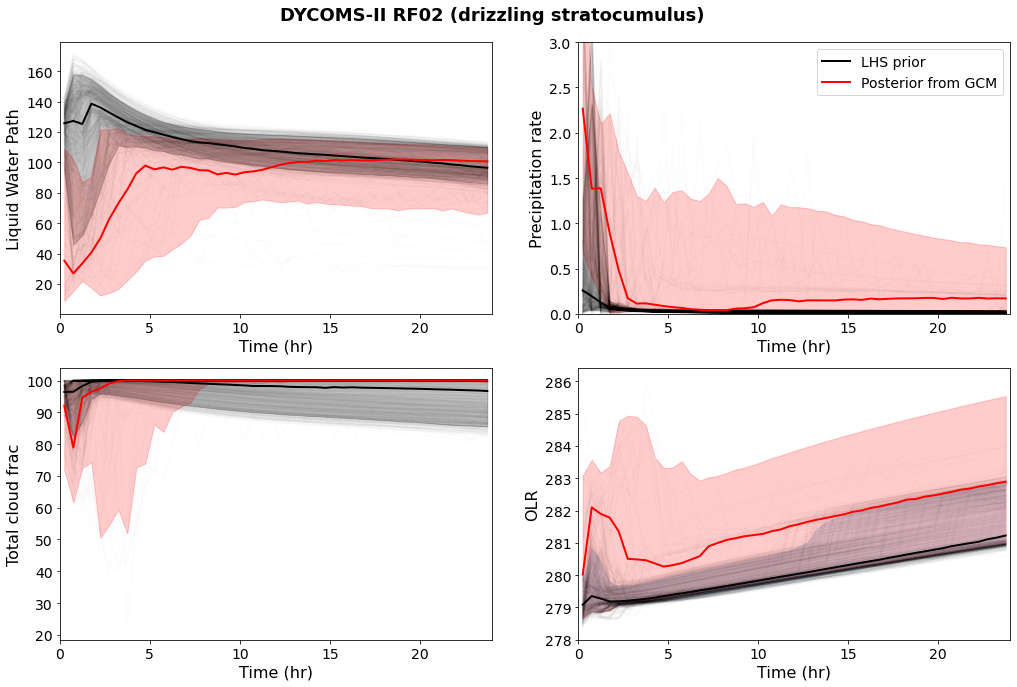

In [187]:
maxt = 24
fig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(2,2)
#
ax = fig.add_subplot(gs[0])
stuff = ax.plot(time,all_lwp,'k',alpha=.01)
ax.fill_between(time, lwp_pct[2,:], lwp_pct[0,:],color='k', alpha=0.2)
ax.plot(time,lwp_pct[1,:],'k',lw=2)
ax.fill_between(time, lwp_pct_post[2,:], lwp_pct_post[0,:],color='r', alpha=0.2)
ax.plot(time,lwp_pct_post[1,:],'r',lw=2)
ax.set_xlim(0.,maxt)
ax.set_ylabel('Liquid Water Path',fontsize=16)
ax.set_xlabel('Time (hr)',fontsize=16)
#
ax = fig.add_subplot(gs[1])
stuff = ax.plot(time,all_prec,'k',alpha=.01)
ax.fill_between(time, prec_pct[2,:], prec_pct[0,:], color='k',alpha=0.2)
ax.plot(time,prec_pct[1,:],'k',lw=2,label='LHS prior')
ax.fill_between(time, prec_pct_post[2,:], prec_pct_post[0,:],color='r', alpha=0.2)
ax.plot(time,prec_pct_post[1,:],'r',lw=2,label='Posterior from GCM')
ax.set_ylim(0,3.)
ax.set_xlim(0.,maxt)
ax.set_ylabel('Precipitation rate',fontsize=16)
ax.set_xlabel('Time (hr)',fontsize=16)
ax.legend(fontsize=14)
#
ax = fig.add_subplot(gs[2])
stuff = ax.plot(time,all_cldtot,'k',alpha=.01)
ax.fill_between(time, cldt_pct[2,:], cldt_pct[0,:], color='k',alpha=0.2)
ax.plot(time,cldt_pct[1,:],'k',lw=2)
ax.fill_between(time, cldt_pct_post[2,:], cldt_pct_post[0,:],color='r', alpha=0.2)
ax.plot(time,cldt_pct_post[1,:],'r',lw=2)
ax.set_xlim(0.,maxt)
ax.set_ylabel('Total cloud frac',fontsize=16)
ax.set_xlabel('Time (hr)',fontsize=16)
#..
ax = fig.add_subplot(gs[3])
stuff = ax.plot(time,all_olr,'k',alpha=.01)
ax.fill_between(time, olr_pct[2,:], olr_pct[0,:], alpha=0.2)
ax.plot(time,olr_pct[1,:],'k',lw=2)
ax.fill_between(time, olr_pct_post[2,:], olr_pct_post[0,:],color='r', alpha=0.2)
ax.plot(time,olr_pct_post[1,:],'r',lw=2)
ax.set_xlim(0.,maxt)
ax.set_ylabel('OLR',fontsize=16)
ax.set_xlabel('Time (hr)',fontsize=16)
#..
gs.update(top=.93,bottom=.1,left=.1,right=.98)
#..
if (case=='dycoms'):
    plt.suptitle('DYCOMS-II RF02 (drizzling stratocumulus)',fontsize=18,fontweight='bold')
    fig.savefig('modelE_scm_dycoms_ts_00.png')

In [101]:
print(all_lwp[0,:].shape)
print(all_lwp[0,:])

(850,)
[121.28109741 128.432724   131.1036377  125.71289825 121.14644623
 114.58677673 130.66316223 125.15232086 114.00137329 122.01113129
 118.01967621 123.7324295   96.57982635  96.69979095 117.92219543
 122.57720947 130.26139832 140.79858398 105.51815033 114.27852631
 120.48062897 115.08493042 140.7983551  132.52915955 132.59010315
 129.11906433 120.8118515  107.52799988  18.87969971   9.58458424
 118.56192017  97.83730316 136.82391357 113.38505554 132.05834961
 100.72813416 139.41030884 117.4020462  129.00463867 136.4309082
 132.04949951 113.04827881 100.23026276 124.9302597  120.33209991
 115.19012451 134.5874176  133.78268433 125.25080109 118.92758942
 133.62330627 139.59802246 130.73652649 142.33076477 134.38717651
 113.04821014 128.39503479 135.05831909 140.5697937   51.92105484
 125.69728851 114.79216766 108.29699707  41.37507629 131.96304321
 115.86133575 117.5322113  128.69958496 126.48874664 110.18395233
 112.133255   126.07421112  96.08847046 120.25885773 113.16492462
 106

In [34]:
print(allpar)

[[2.15066e+03 2.15066e+03 2.15066e+03 ... 2.15066e+03 2.15066e+03
  2.15066e+03]
 [4.21590e+01 4.21590e+01 4.21590e+01 ... 4.21590e+01 4.21590e+01
  4.21590e+01]
 [1.10259e+02 1.10259e+02 1.10259e+02 ... 1.10259e+02 1.10259e+02
  1.10259e+02]
 ...
 [8.54739e-01 8.54739e-01 8.54739e-01 ... 8.54739e-01 8.54739e-01
  8.54739e-01]
 [1.25661e+00 1.25661e+00 1.25661e+00 ... 1.25661e+00 1.25661e+00
  1.25661e+00]
 [1.51426e+01 1.51426e+01 1.51426e+01 ... 1.51426e+01 1.51426e+01
  1.51426e+01]]


In [35]:
np.savetxt('param_ens.txt',allpar)

In [172]:
#..Look at ensemble of profiles (precipitation flux?)
numpar = 45
nt     = 48
nz     = 110
#..

#..Get the folowing profiels
tidx_start = 20    #..hr 10 if 30 min dt
tidx_end   = 30    #..hr 15 if 30 min dt

#..
all_qpl = np.zeros((nz,num_main_ppe))
all_qcl = np.zeros((nz,num_main_ppe))
all_dth = np.zeros((nz,num_main_ppe))

all_qpl_post = np.zeros((nz,num_post))
all_qcl_post = np.zeros((nz,num_post))
all_dth_post = np.zeros((nz,num_post))


#..Now do this for all ensemble members
for i in range(num_main_ppe):
    #..Pick one. First see if we can read parameters
    par_dict = {}
    pars = []
    parnames = list()
    with open(main_dir+subdir_list[i]+'/I') as myfile:
        for myline in myfile:
            if (myline[0]==' '):
                pass
            else:
                r = re.findall(r'([a-zA-Z]*)=(\S+)',myline)
                for name,val in r:
                    if val:
                        pars = np.r_[pars,float(val)]
                    parnames = parnames + [name]
                idict={name:float(val) for name,val in r}
                par_dict.update(idict)
    #..
    #nc = Dataset(main_dir+subdir_list[i]+'/allsteps.cijh1SCM_'+case_upper+'_jingbo'+str(i+1).zfill(3)+'F110.nc','r')
    nc = Dataset(main_dir+subdir_list[i]+'/allsteps.cijlh1SCM_'+case_upper+'_gse'+str(i+1).zfill(3)+'F110.nc','r')
    qpl = nc.variables['qpl'][:,:,0,0]
    qcl = nc.variables['qcl'][:,:,0,0]
    pres = nc.variables['p'][:]
    nc.close()
    #..
    nc = Dataset(main_dir+subdir_list[i]+'/allsteps.rijlh1SCM_'+case_upper+'_gse'+str(i+1).zfill(3)+'F110.nc','r')
    dth_rad = nc.variables['dth_rad'][:,:,0,0]
    nc.close()
    #..
    #
    all_qpl[:,i] = qpl[tidx_start:tidx_end,:].mean(axis=0)
    all_qcl[:,i] = qcl[tidx_start:tidx_end,:].mean(axis=0)
    all_dth[:,i] = dth_rad[tidx_start:tidx_end,:].mean(axis=0)
    
#..Now do this for all ensemble members
ii = 0
for i in range(num_main_ppe+100,num_subdir):    #..Pick one. First see if we can read parameters
    #par_dict = {}
    pars_post = []
    #parnames = list()
    with open(main_dir+subdir_list[i]+'/I') as myfile:
        for myline in myfile:
            if (myline[0]==' '):
                pass
            else:
                r = re.findall(r'([a-zA-Z]*)=(\S+)',myline)
                for name,val in r:
                    if val:
                        pars = np.r_[pars,float(val)]
                    #parnames = parnames + [name]
                #idict={name:float(val) for name,val in r}
                #par_dict.update(idict)
    #..
    #nc = Dataset(main_dir+subdir_list[i]+'/allsteps.cijh1SCM_'+case_upper+'_jingbo'+str(i+1).zfill(3)+'F110.nc','r')
    nc = Dataset(main_dir+subdir_list[i]+'/allsteps.cijlh1SCM_'+case_upper+'_gse'+str(i+1).zfill(3)+'F110.nc','r')
    qpl_post = nc.variables['qpl'][:,:,0,0]
    qcl_post = nc.variables['qcl'][:,:,0,0]
    pres = nc.variables['p'][:]
    nc.close()
    #..
    nc = Dataset(main_dir+subdir_list[i]+'/allsteps.rijlh1SCM_'+case_upper+'_gse'+str(i+1).zfill(3)+'F110.nc','r')
    dth_rad_post = nc.variables['dth_rad'][:,:,0,0]
    nc.close()
    #..
    #
    all_qpl_post[:,ii] = qpl_post[tidx_start:tidx_end,:].mean(axis=0)
    all_qcl_post[:,ii] = qcl_post[tidx_start:tidx_end,:].mean(axis=0)
    all_dth_post[:,ii] = dth_rad_post[tidx_start:tidx_end,:].mean(axis=0)
    ii += 1

In [173]:
#..Cacalate 90th, 50th, 10th percentile
pctiles = [90,50,10]
qpl_pct = np.percentile(all_qpl,pctiles,axis=1)
qcl_pct = np.percentile(all_qcl,pctiles,axis=1)
dth_pct = np.percentile(all_dth,pctiles,axis=1)
print(qpl_pct.shape)

qpl_post_pct = np.percentile(all_qpl_post,pctiles,axis=1)
qcl_post_pct = np.percentile(all_qcl_post,pctiles,axis=1)
dth_post_pct = np.percentile(all_dth_post,pctiles,axis=1)
#..
# lwp_pct_post  = np.percentile(all_lwp_post,pctiles,axis=1)
# prec_pct_post = np.percentile(all_prec_post,pctiles,axis=1)
# cldt_pct_post = np.percentile(all_cldtot_post,pctiles,axis=1)
# olr_pct_post  = np.percentile(all_olr_post,pctiles,axis=1)
# print(lwp_pct_post.shape)

(3, 110)


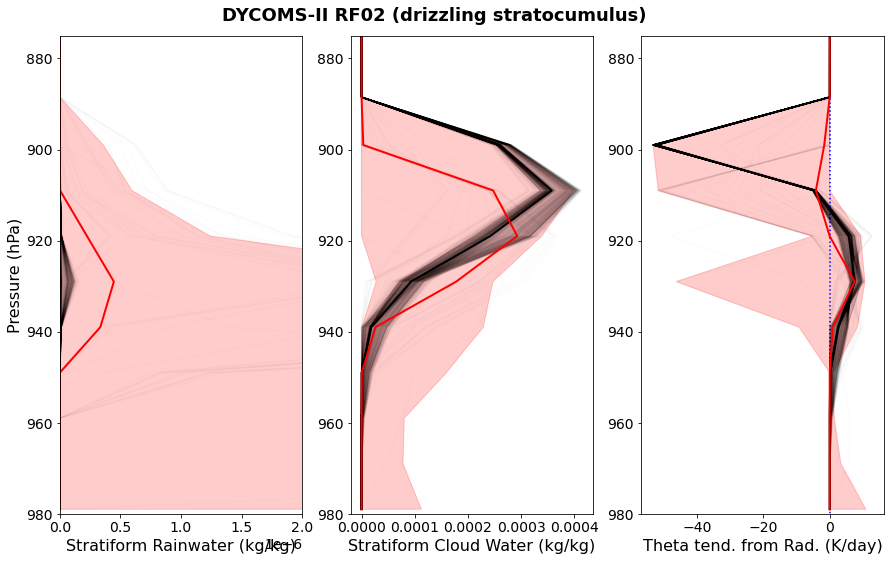

In [195]:
fig = plt.figure(figsize=(13,8))
gs = gridspec.GridSpec(1,3)
ax = fig.add_subplot(gs[0])
stuff = ax.plot(all_qpl,pres,'k',alpha=.01)
ax.fill_betweenx(pres,qpl_pct[2,:], qpl_pct[0,:], color='k',alpha=0.2)
ax.plot(qpl_pct[1,:],pres,'k',lw=2)
ax.fill_betweenx(pres,qpl_post_pct[2,:], qpl_post_pct[0,:], color='r',alpha=0.2)
ax.plot(qpl_post_pct[1,:],pres,'r',lw=2)
ax.invert_yaxis()
ax.set_ylim(980,875)
ax.set_xlim(0.,2.e-6)
ax.set_xlabel('Stratiform Rainwater (kg/kg)',fontsize=16)
ax.set_ylabel('Pressure (hPa)',fontsize=16)
#..
ax = fig.add_subplot(gs[1])
stuff = ax.plot(all_qcl,pres,'k',alpha=.01)
ax.fill_betweenx(pres,qcl_pct[2,:], qcl_pct[0,:], color='k',alpha=0.2)
ax.plot(qcl_pct[1,:],pres,'k',lw=2)
ax.fill_betweenx(pres,qcl_post_pct[2,:], qcl_post_pct[0,:], color='r',alpha=0.2)
ax.plot(qcl_post_pct[1,:],pres,'r',lw=2)
ax.invert_yaxis()
ax.set_ylim(980,875)
#ax.set_xlim(0.,1.e-5)
ax.set_xlabel('Stratiform Cloud Water (kg/kg)',fontsize=16)
#..
ax = fig.add_subplot(gs[2])
ax.plot([0.,0.],[100,1000.],'b:')
stuff = ax.plot(all_dth,pres,'k',alpha=.01)
ax.fill_betweenx(pres,dth_pct[2,:], dth_pct[0,:], color='k',alpha=0.2)
ax.plot(dth_pct[1,:],pres,'k',lw=2)
ax.fill_betweenx(pres,dth_post_pct[2,:], dth_post_pct[0,:], color='r',alpha=0.2)
ax.plot(dth_post_pct[1,:],pres,'r',lw=2)
ax.invert_yaxis()
ax.set_ylim(980,875)
#ax.set_xlim(0.,1.e-5)
ax.set_xlabel('Theta tend. from Rad. (K/day)',fontsize=16)

gs.update(top=.93,bottom=.1,left=.1,right=.98,wspace=.2)

if (case=='dycoms'):
    plt.suptitle('DYCOMS-II RF02 (drizzling stratocumulus)',fontsize=18,fontweight='bold')
    fig.savefig('modelE_scm_dycoms_prof_00.png')
    